# Random Generation of N-Qubit Mixed Quantum States
Notebook containing various plots analyzing and comparing different methods for random state generation.

In [1]:
# global imports
import numpy as np
import matplotlib.pyplot as plt
import random_states
from random_states import SX, SY, SZ # pauli spin matrices
import concurrence

# Pure States

# Generation Methods

There are a number of methods that are generally used for generating "random" quantum states. Here we will examine a few of these methods.

## Standard Method
The so-called "standard method" recognizes that any physical density matrix $\rho$ can be diagonalized in a an orthonormal basis $\ket{\lambda}$ so that $$\rho = \sum_i \lambda_i\ket{\lambda_i}\bra{p_i}$$. Then, since transformations between orthonormal bases are given by unitary matricies, we can use any method we choose to generate a random unitary matrix, then assign each of the new basis vectors a random eigenvalue $0 \leq \lambda_i \leq 1$, subject to the constraint that $\sum_i \lambda_i = 1$.

## Standard+ Method\*
This is exactly the same as the standard method, except we attempt to be significantly more intelligent about how we select the eigenvalues $\lambda_i$. In particular, instead of just generating a random vector in the unit cube and normalizing it according to it's sum, we generate a random vector on the unit *sphere* $x_i$ and use eigenvalues $\lambda_i = x_i^2$. We do this in the hopes that such a generation process will provide a more "fair" sampling of random quantum states.

## Bloch-Vector Parameterization (Not Used)
This process recognizes that we can come up with a set of Hermitian, traceless, orthonormal generators for the special unitary group (which we will call $\Gamma_i$), and then along with $\mathbb{I}$ we can generate any physical density matrix (for a two-qubit system) as $$\rho = \frac{\mathbb{I}}{4} + \sum_i \gamma_i \Gamma_i$$ for some parameters $\gamma_i$. According to [this paper](https://link.springer.com/article/10.1007/s13538-015-0367-2#ref-CR53), a common choice is the generalized Gell-Mann matrices. However these cause problems as the valid range for the $\gamma_i$ parameters is not very well defined, leading to essentially all (of my) attempts to use this method generating density matrices with negative eigenvalues.

However, I was able to develop a highly related and very simmilar method that works much better...

## Pauli-Vector Parameterization
Instead of using the Gell-Mann matricies as our basis, we use the orthonormal, traceless, and Hermitian basis of $\sigma_i\otimes\sigma_j$ for $\sigma\in\{0,\sigma_x, \sigma_y, \sigma_z\}$. This method follows the exact same procedure as before, **however**, the expectation values for $\sigma_i\otimes\sigma_j$ for any physical state are very well defined ($\langle\sigma_i\otimes\sigma_j\rangle \in [-1,1]$) and so the corresponding eigenvalues therefore have the same well-defined bounds.

It is unclear why, but this method leads to a significantly higher probability of obtaining a physical density matrix than the Bloch-vector parameterization.

Below is a histogram of how many tries it took to get vector corresponding to a valid physical state. As a reminder, even letting my code run for minutes, I was unable to generate a valid state with the Bloch-vector parameterization.

Mean number of tries: 14.6574


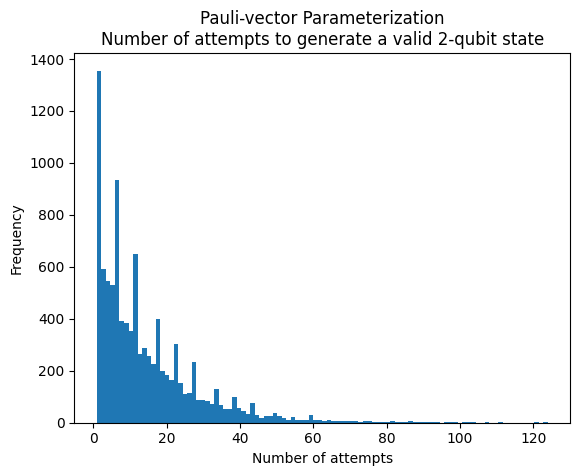

In [9]:
# code generates and plots frequency data

# generate data
data = []
for _ in range(10000):
    c = 1
    rho = random_states.RDM3(4, safe=False)
    while np.any(np.linalg.eigvals(rho).real < 0):
        rho = random_states.RDM3(4, safe=False)
        c += 1
    data.append(c)

# plot data
plt.hist(data, bins=100)
plt.xlabel('Number of attempts')
plt.ylabel('Frequency')
plt.title('Pauli-vector Parameterization\nNumber of attempts to generate a valid 2-qubit state')

print(f'Mean number of tries: {np.mean(data)}')

## Trace Method
In this method, to obtain a random quantum system with $n$ qubits, we start with a pure state of $2n$ qubits (for which, a generally accepted definition of "randomness" has been reached). Then we generate the density matrix for this system, and compute the partial trace with respect to the second sub-system.

It's pretty trivial to show (read as: "I was able to show, so it can't be that hard") that this method is mathematically equivalent to picking $2^n$ random pure states for $n$ qubits, and combining them together with $2^n$ random probabilities, which is theoretically more computationally effective, but also opens another can of worms...

## N-Trace Method
This method generalizes the trace method by computing $n$ pure states and mixing them together with n 

## Over Parameterized Method
This method recognizes that any complex matrix $A$ will have $A^\dagger A\geq 0$ (positive semidefinite) and so if we normalize $A$ according to $$\mathcal{A} \coloneqq \frac{A}{||A||_2}$$ where $$||A||_2 = \sqrt{\langle A | A \rangle}$$ and the Hilbert-Schmidt inner product is $$\langle A | B \rangle = \text{Tr}(A^\dagger B)$$
We will obtain a valid density operator $\rho = \mathcal{A}^\dagger\mathcal{A}$.

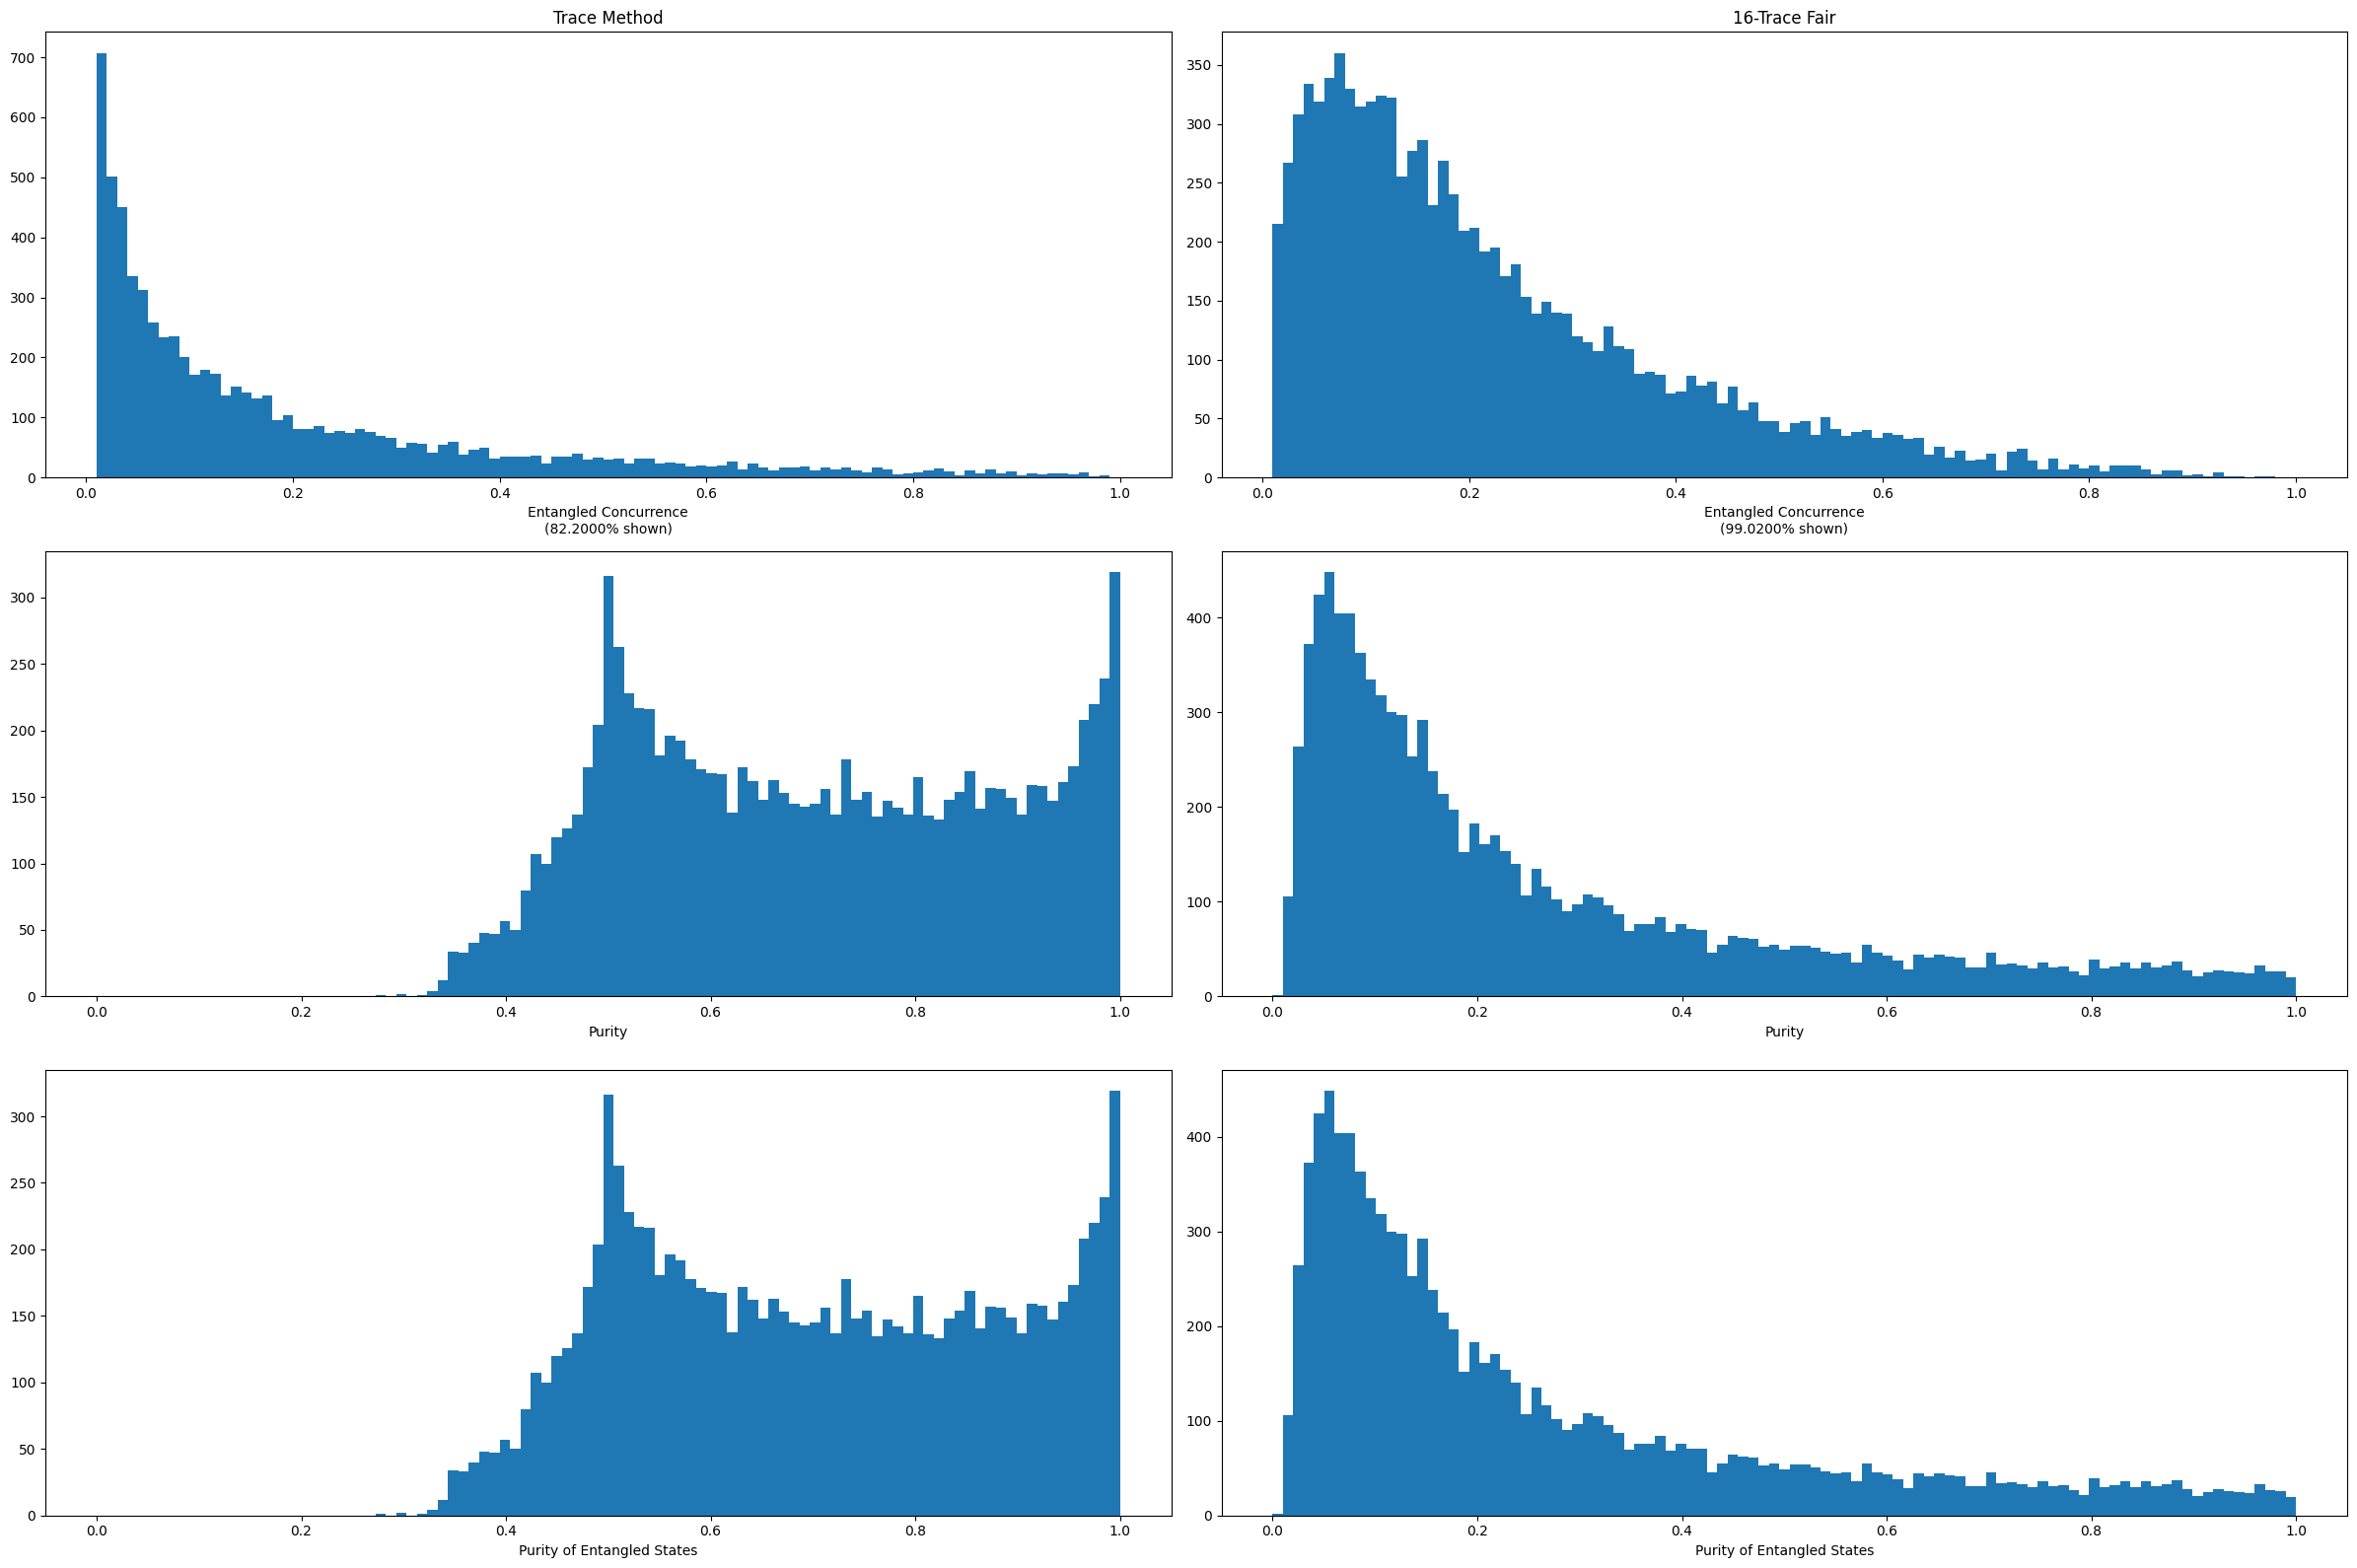

Percent of states that are entangled:
	Trace Method: 82.2000%
	16-Trace Fair: 99.0200%
Concurrence:
	Trace Method: mean = 0.1340%, std = 0.1920%
	16-Trace Fair: mean = 0.2185%, std = 0.1781%
Purity:
	Trace Method: mean = 0.7001%, std = 0.1802%
	16-Trace Fair: mean = 0.2668%, std = 0.2446%
Purity of Entangled States:
	Trace Method: mean = 0.4727%, std = 0.3111%
	16-Trace Fair: mean = 0.4727%, std = 0.3111%


In [2]:

N = 10000
names = np.array([
    'Trace Method',
    # '16-Trace Uniform',
    # '16-Trace Gaussian',
    '16-Trace Fair'])
funcs = [
    random_states.RDM2,
    # random_states.RDM4,
    # random_states.RDM4,
    random_states.RDM4,]
kwargs = [
    dict(),
    # dict(n=4, dist='uniform'), 
    # dict(n=4, dist='gaussian'), 
    dict(n=4, dist='fair')]

n_test = len(names)
rhos = np.array([[f(4,**kwarg) for _ in range(N)] for f, kwarg in zip(funcs, kwargs)])


# calculate concurrence for each method
conc = np.zeros((n_test, N)) # concurrence for each state
pct_ent = np.zeros(n_test) # this will hold total number of entangled states
purity = np.zeros((n_test, N)) # purity of each state
purity_of_ent = [[]]*n_test # this will hold purity of entangled states

# calculate stats for each method
for i in range(n_test):
    for j in range(N):
        # calculate stats
        conc[i,j] = concurrence.concurrence(rhos[i,j])
        purity[i,j] = np.trace(rhos[i,j] @ rhos[i,j]).real
        # special stuff for entangled states
        if conc[i,j] > 0:
            pct_ent[i] += 1
            purity_of_ent[i].append(purity[i,j])

# normalize the percent of states that are entangled
pct_ent = 100 * pct_ent/N

# generating plots for these values

fig = plt.figure(figsize=(24,16))

BINS = 100
for i in range(n_test):
    # concurrence
    ax = fig.add_subplot(3,n_test,i+1)
    ax.hist(conc[i], bins=np.linspace(0.01,1,BINS))
    ax.set_xlabel(f'Entangled Concurrence\n({pct_ent[i]:.4f}% shown)')
    ax.set_title(f'{names[i]}')

    # purity
    ax = fig.add_subplot(3,n_test,n_test+i+1)
    ax.hist(purity[i], bins=np.linspace(0,1,BINS))
    ax.set_xlabel('Purity')

    # purity
    ax = fig.add_subplot(3,n_test,2*n_test+i+1)
    ax.hist(purity[i], bins=np.linspace(0,1,BINS))
    ax.set_xlabel('Purity of Entangled States')

# make the plot
fig.tight_layout()
plt.show()

# print stats
print(f'Percent of states that are entangled:')
for i in range(n_test):
    print(f'\t{names[i]}: {pct_ent[i]:.4f}%')
print(f'Concurrence:')
for i in range(n_test):
    print(f'\t{names[i]}: mean = {np.average(conc[i]):.4f}%, std = {np.std(conc[i]):.4f}%')
print(f'Purity:')
for i in range(n_test):
    print(f'\t{names[i]}: mean = {np.average(purity[i]):.4f}%, std = {np.std(purity[i]):.4f}%')
print(f'Purity of Entangled States:')
for i in range(n_test):
    print(f'\t{names[i]}: mean = {np.average(purity_of_ent[i]):.4f}%, std = {np.std(purity_of_ent[i]):.4f}%')

# Generation

Code that generates the density matricies that we will gather stats about. The methods used by the functions below are outlined in the next section.

In [4]:
N = 5000 # number of states to generate for plot

# define names of methods
names = np.array([
    'Standard',
    'Trace',
    'Pauli',
    'Direct (n=8)',
    'OP Uniform Non Negative',
    'OP Uniform',
    'OP Gaussian'])
funcs = [
    random_states.RDM1,
    random_states.RDM2,
    random_states.RDM3,
    random_states.RDM4,
    random_states.RDM5,
    random_states.RDM5,
    random_states.RDM5]
two_qubit_args = [
    (), 
    (), 
    (), 
    (8,), 
    ('uniform non negative',), 
    ('uniform',),
    ('gaussian',)]
one_qubit_args = [
    (), 
    (), 
    (), 
    (8,), 
    ('uniform non negative',), 
    ('uniform',), 
    ('gaussian',)]
# number of methods being tested
n_test = len(names)


# generate the density matricies using all methods
rhos = np.array([[f(4,*args) for _ in range(N)] for f, args in zip(funcs, two_qubit_args)])
# generate density matricies for one qubit using all methods
one_rhos = np.array([[f(2,*args) for _ in range(N)] for f, args in zip(funcs, one_qubit_args)])

# Initial Comparison of Random Generation for 2 Qubit States

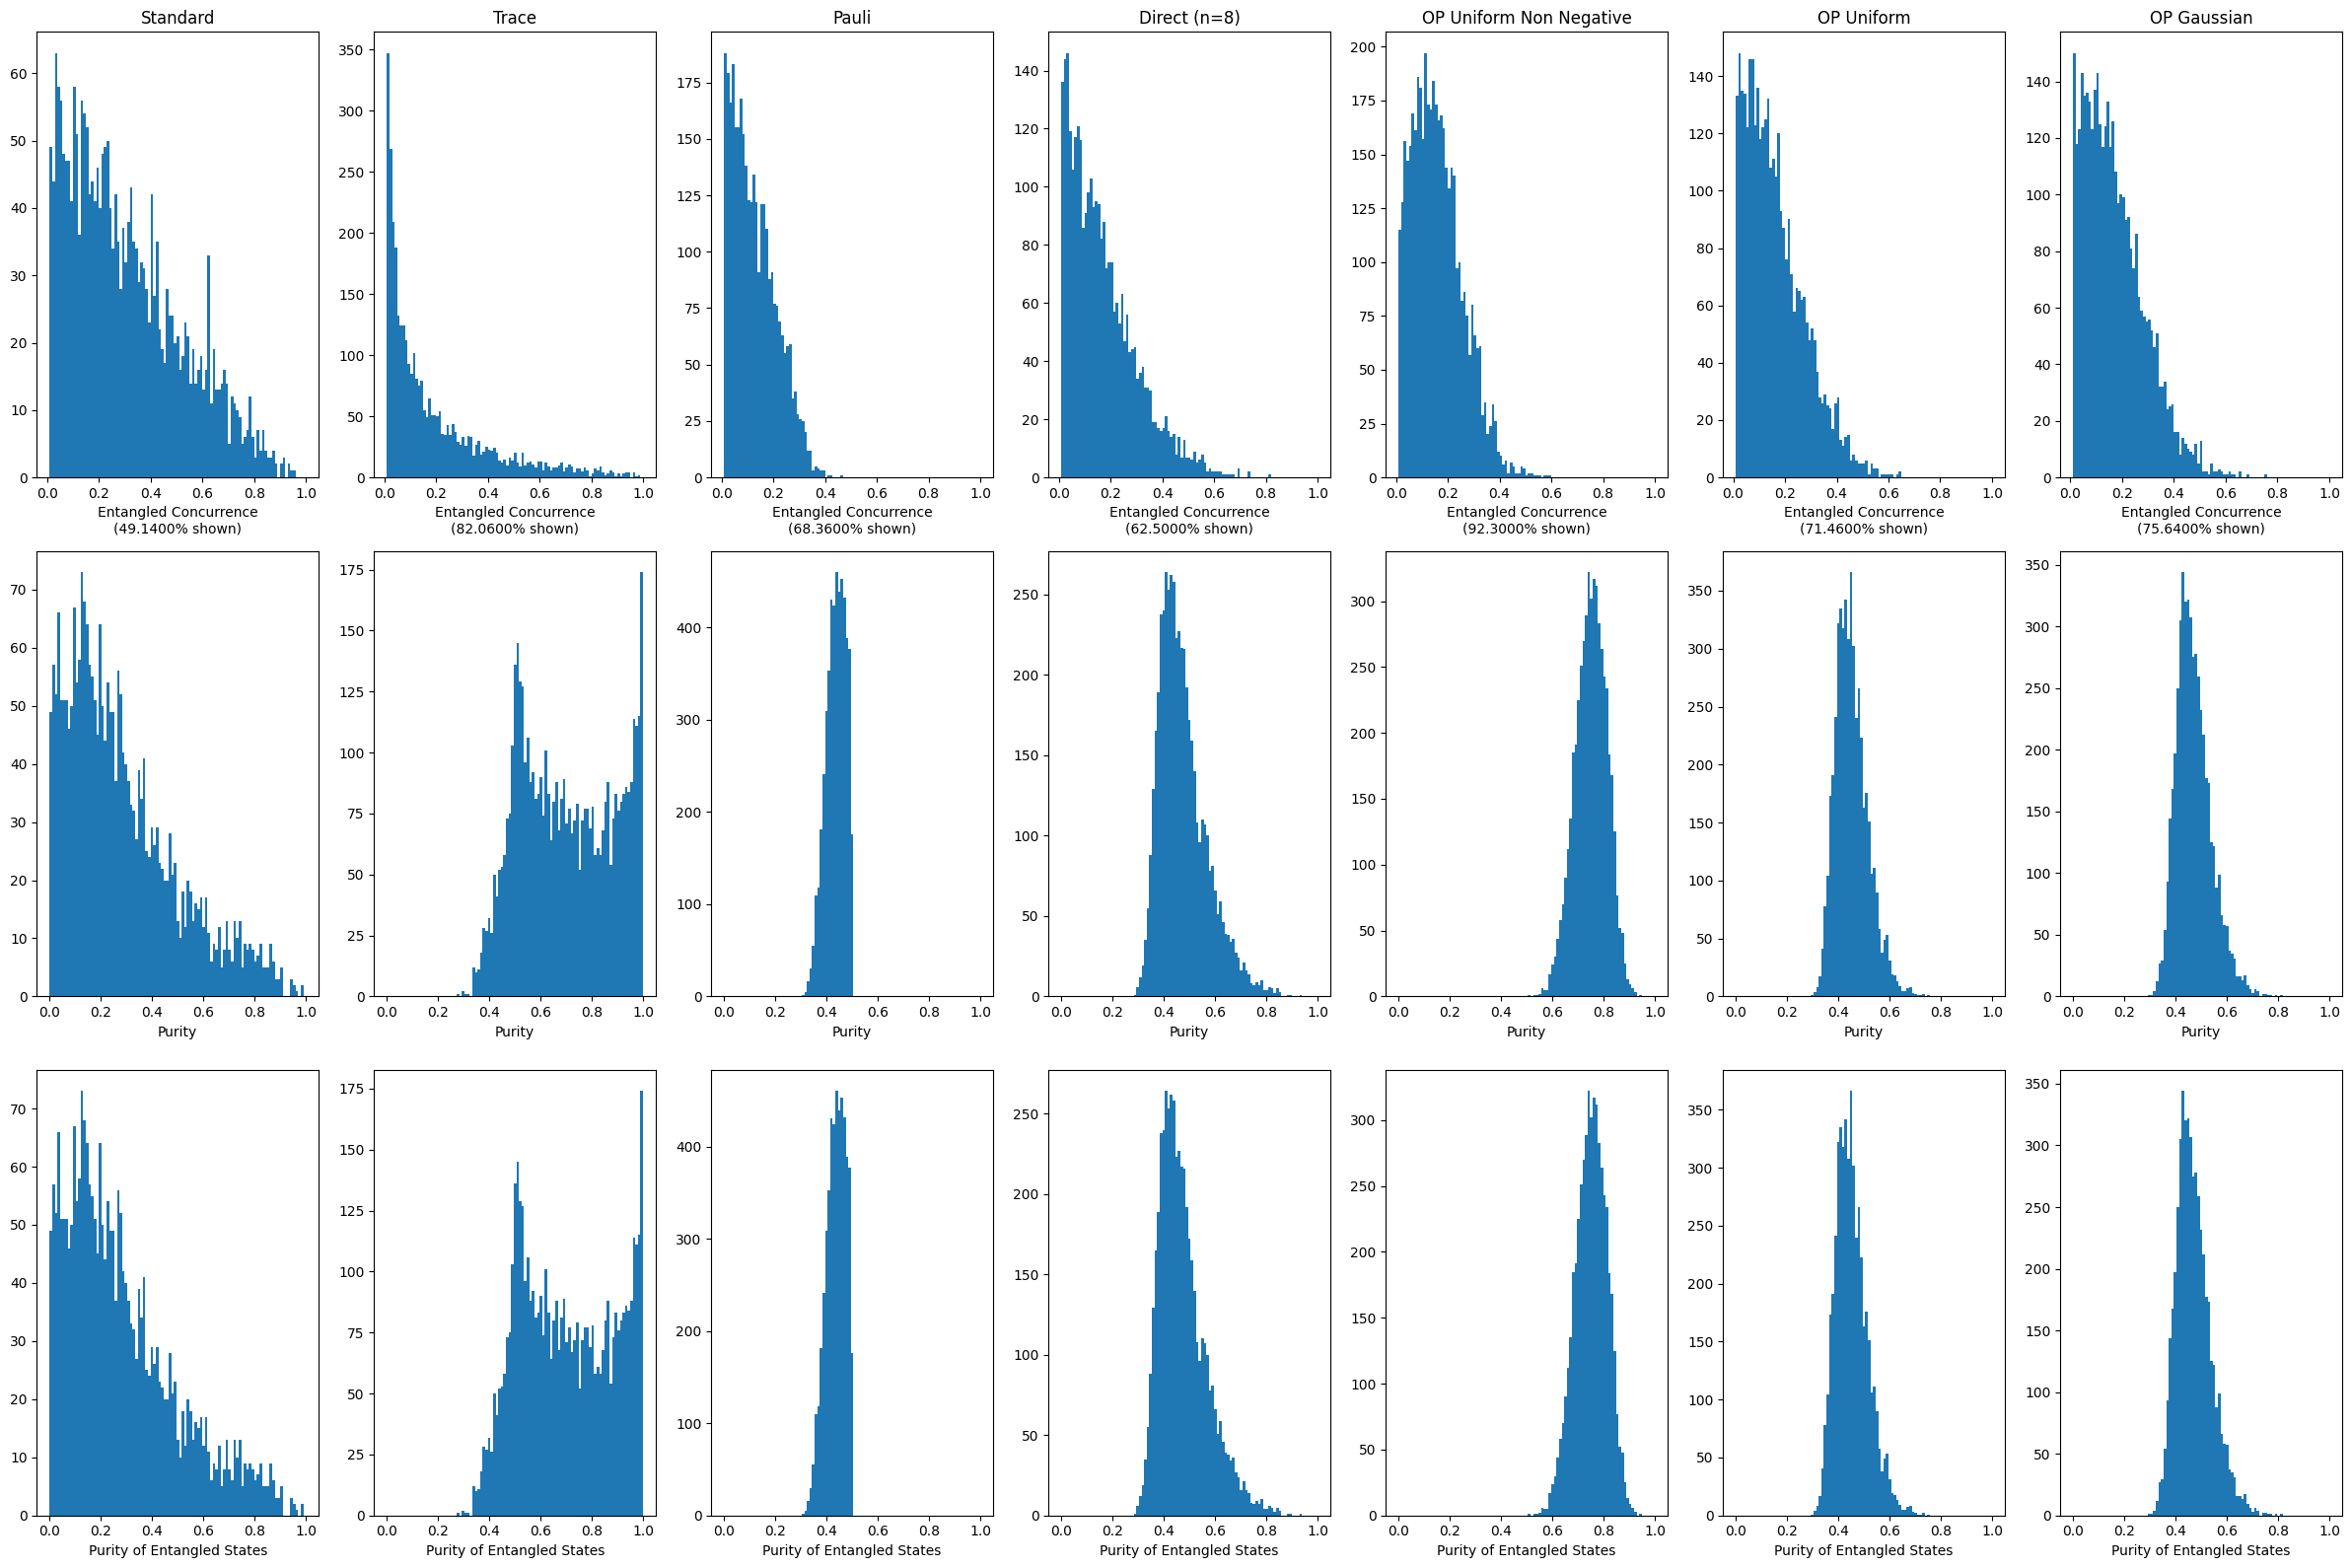

In [5]:
BINS = 100

# calculate concurrence for each method
conc = np.zeros((n_test, N)) # concurrence for each state
pct_ent = np.zeros(n_test) # this will hold total number of entangled states
purity = np.zeros((n_test, N)) # purity of each state
purity_of_ent = [[]]*n_test # this will hold purity of entangled states

# calculate stats for each method
for i in range(n_test):
    for j in range(N):
        # calculate stats
        conc[i,j] = concurrence.concurrence(rhos[i,j])
        purity[i,j] = np.trace(rhos[i,j] @ rhos[i,j]).real
        # special stuff for entangled states
        if conc[i,j] > 0:
            pct_ent[i] += 1
            purity_of_ent[i].append(purity[i,j])

# normalize the percent of states that are entangled
pct_ent = 100 * pct_ent/N

# generating plots for these values

fig = plt.figure(figsize=(24,16))

for i in range(n_test):
    # concurrence
    ax = fig.add_subplot(3,n_test,i+1)
    ax.hist(conc[i], bins=np.linspace(0.01,1,BINS))
    ax.set_xlabel(f'Entangled Concurrence\n({pct_ent[i]:.4f}% shown)')
    ax.set_title(f'{names[i]}')

    # purity
    ax = fig.add_subplot(3,n_test,n_test+i+1)
    ax.hist(purity[i], bins=np.linspace(0,1,BINS))
    ax.set_xlabel('Purity')

    # purity
    ax = fig.add_subplot(3,n_test,2*n_test+i+1)
    ax.hist(purity[i], bins=np.linspace(0,1,BINS))
    ax.set_xlabel('Purity of Entangled States')

# make the plot
fig.tight_layout()
plt.show()

These results being different forces us to confront what we actually mean by a random state. How do we want these random states to be distributed and why? 

# Visualizing One-Qubit Generation Geometries

Here we use the bloch-sphere visualization of mixed one-qubit states to gain some understanding of the distribution of each of our random generation methods in the pauli basis.

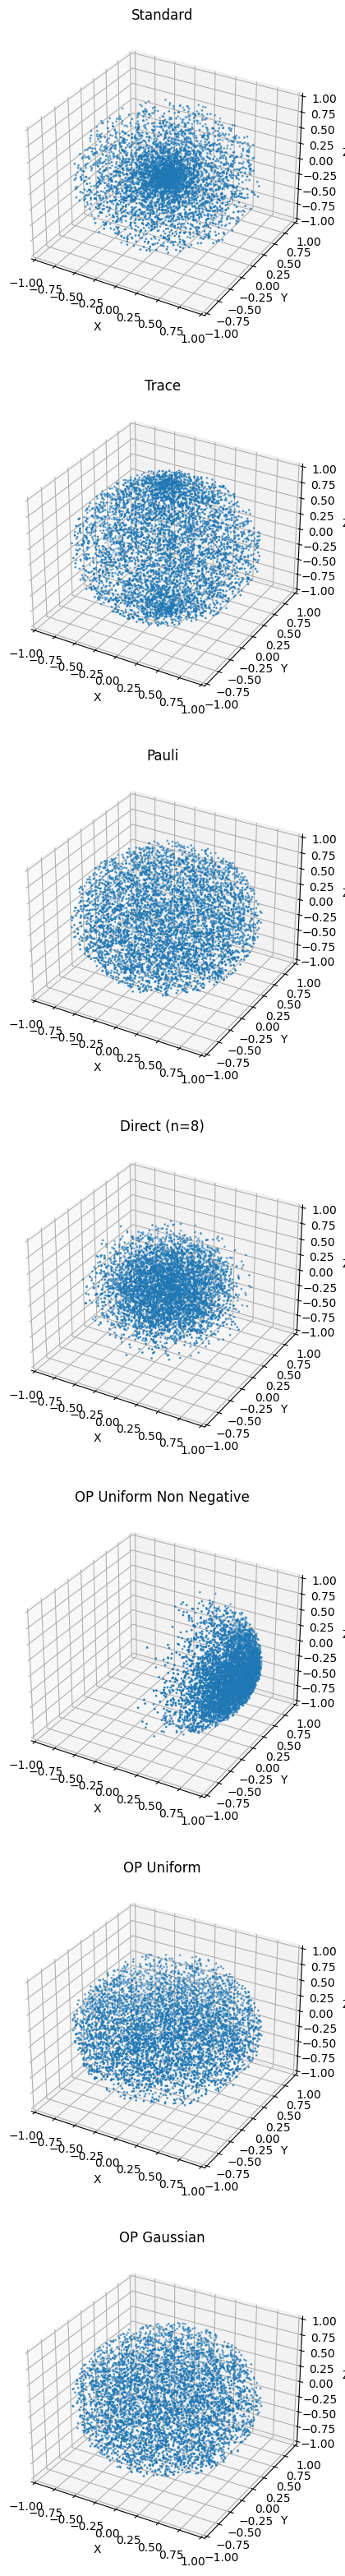

In [6]:
# define the pauli spin matrices
def func(x,S):
    return np.trace(S @ x)

coords = np.zeros((n_test, 3, N))

for i in range(n_test):
    coords[i,0] = np.array([func(x,SX) for x in one_rhos[i]]).real
    coords[i,1] = np.array([func(x,SY) for x in one_rhos[i]]).real
    coords[i,2] = np.array([func(x,SZ) for x in one_rhos[i]]).real


# plot the results
fig = plt.figure(figsize=(8,40))

for i in range(n_test):
    ax = fig.add_subplot(n_test,1,i+1,projection='3d')
    ax.scatter(coords[i,0], coords[i,1], coords[i,2], s=1)
    ax.set_title(f'{names[i]}')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.show()

# Investigation of Distances Between States

To analyze the geometries above, we need to define a measure of distance. There are a few common choices we will use in our analysis here.

1. Firstly, we have the Hilbert-Schmidt distance, defined as $$\text{HSD}(A,B) = ||A-B||_2$$ where $$||A||_2=\sqrt{\langle A | A \rangle}=\sqrt{\text{Tr}(A^\dagger A)}=\sqrt{\sum_i\lambda_i}$$
where $\lambda_i$ are the eigenvalues of $A$. Importantly though, notice that if we express $A$ and $B$ in terms of the pauli-basis $A=r_A^j\sigma_j/d$ and $B=r_B^i\sigma_i/d$ (we are leaving the normalization as $d$ since this fact generalizes to higher dimensions $d\geq 2$) then we have $A-B=(r_A^i-r_B^i)\sigma_i/d$ and since all $\sigma_i$ are Hermitian and all $r_C^i$ are real, $(A-B)^\dagger = A-B$ and so $(A-B)^\dagger(A-B)=(A-B)^2=(r_A^i-r_B^i)(r_A^j-r_B^j)\sigma_i\sigma_j/d^2$. However, when we compute the trace of this and distribute over the (implied) summation, $\text{Tr}(\sigma_i\sigma_j)=d\delta_{ij}$ and so we are left with $$\text{HSD}(A,B)=\sqrt{\sum_i (r_A^i-r_B^i)^2/d}=|\vec{r}|/\sqrt{d}$$ Which shows that the Hilbert-Schmidt distance between two quantum states is proportional to the Euclidean distance between the states in the $\sigma_i$ basis. Note that this fact holds for higher dimensions where the $\sigma_i$ basis is taken to be the power set of tensor products of the two dimensional $\sigma_i=\{\mathbb{I}, \sigma_x, \sigma_y, \sigma_z\}$.
1. The other distance metric analyzed here here is Fidelity. Fidelity is a metric of how simmilar two quantum states are, and so we will actually use 1-fidelity as the distance metric. Fidelity itself is defined as $$F(A,B)=\sqrt{\sqrt{A}B\sqrt{A}}$$


/var/folders/s5/43p8k39n47n1grhym728zgvm0000gn/T/ipykernel_2087/3802382317.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  distances[i,j,k] = distance_metrics[i](rhos[j,k], rho_primes[j,k])


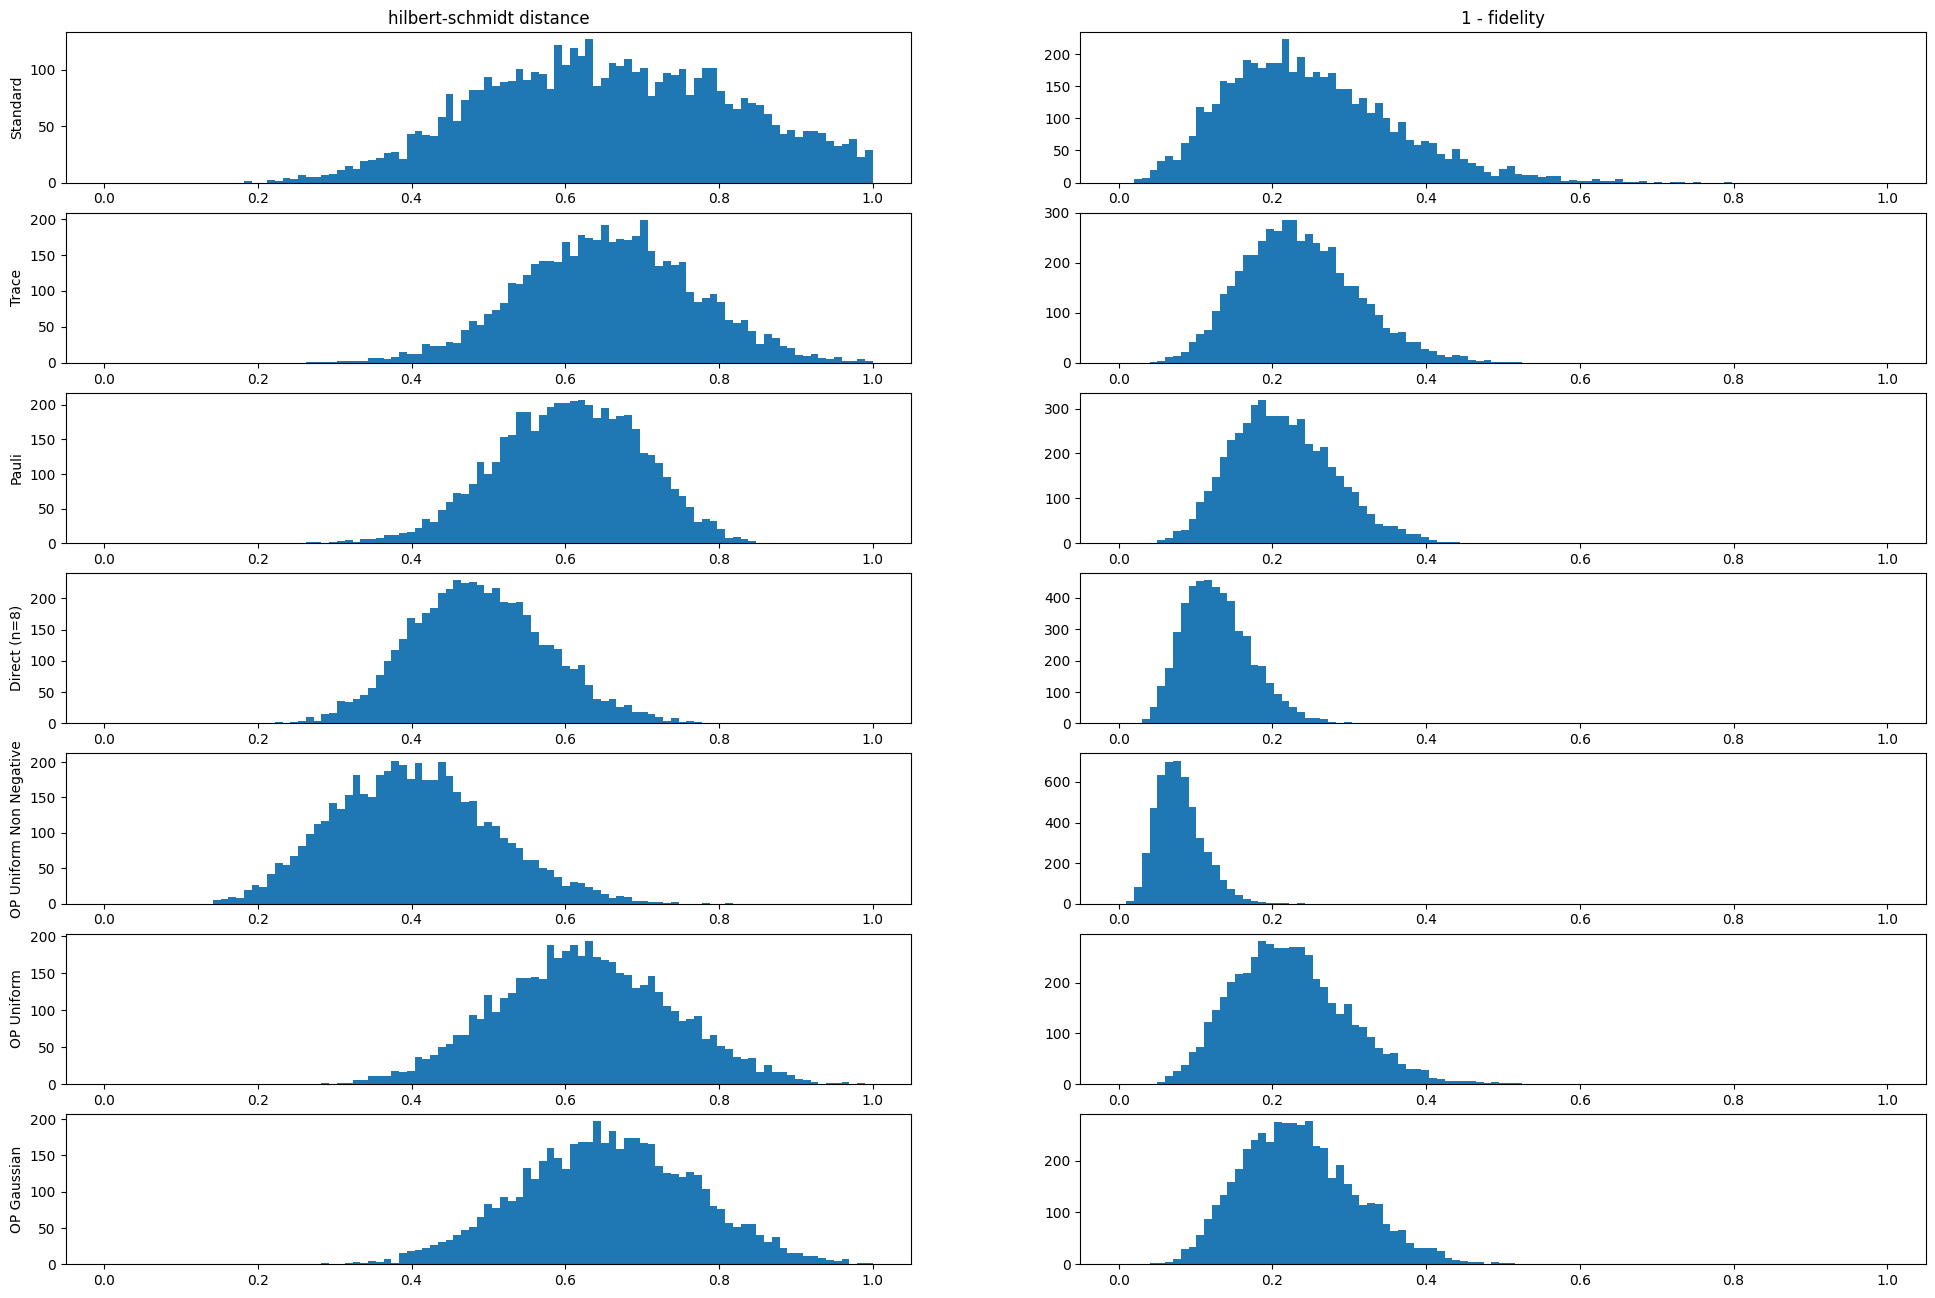

In [10]:
distances_metric_names = [
    'hilbert-schmidt distance',
    '1 - fidelity'
    # 'haar metric'
]
distance_metrics = [
    random_states.HSD,
    random_states.FIDE
]
n_dist = len(distances_metric_names)
DIM = 4


rhos = np.array([[f(DIM, *args) for _ in range(N)] for f, args in zip(funcs, two_qubit_args)])
rho_primes = np.array([[f(DIM, *args) for _ in range(N)] for f, args in zip(funcs, two_qubit_args)])

distances = np.zeros((n_dist, n_test, N))

for i in range(n_dist): 
    for j in range(n_test):
        for k in range(N):
            distances[i,j,k] = distance_metrics[i](rhos[j,k], rho_primes[j,k])

# plotting
fig = plt.figure(figsize=(24,16))

for j in range(n_test): 
    for i in range(n_dist):
        ax = fig.add_subplot(n_test, n_dist, j*n_dist+i+1)
        ax.hist(distances[i,j], bins=np.linspace(0,1,BINS))
        if j == 0:
            ax.set_title(distances_metric_names[i])
        if i == 0:
            ax.set_ylabel(names[j])
plt.show()

In [11]:
one_rhos.shape


(7, 5000, 2, 2)

In [12]:
A = np.random.rand(6,6,6,6)
def func(x,y):
    print(x.shape)
    print(y)
    return y*np.ones_like(x)
B = np.apply_over_axes(func, A, [1,2])

(6, 6, 6, 6)
1
(6, 6, 6, 6)
2


In [13]:
B.max()

2.0

In [14]:
B

array([[[[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2.

In [15]:
B

array([[[[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.]],

        [[2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2.],
         [2.

In [16]:
B.shape

(6, 6, 6, 6)

In [17]:
B.shape

(6, 6, 6, 6)

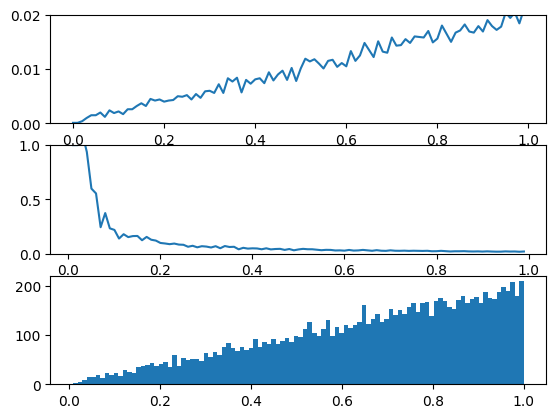

In [18]:
x = np.random.rand(10000)
y = np.sqrt(x)

pdist = np.array([np.sum((i < y)*(y < i+0.01))/10000 for i in np.arange(0,1,0.01)])

plt.subplot(311)
plt.plot(np.arange(0,1,0.01), pdist)
plt.ylim(0,0.02)
plt.subplot(312)
plt.plot(np.arange(0.01,1,0.01), pdist[1:]/np.arange(0.01,1,0.01)**2)
plt.ylim(0,1)
# plt.hist(x, bins=100)
plt.subplot(313)
plt.hist(y, bins=100)
plt.show()

- Summarize the fidelity testing
- 3d geometry testing
- plotting of single qubit stuff
- understanding the geometry of this space???